
* 1. 小批量
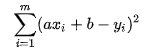
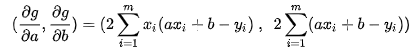
* 2. 为什么要使用小批量：例子：计算A=BC
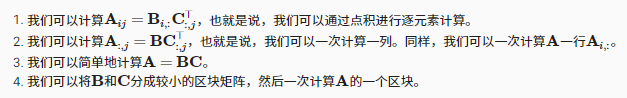
基础知识捎带回顾：
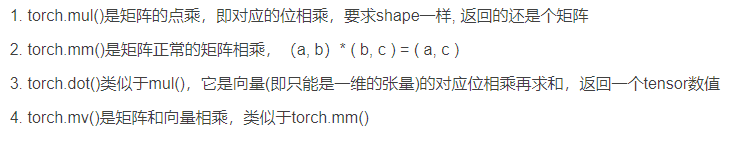
* 3. 读取数据集
* 4. 从零开始实现
* 5. 简洁实现

In [40]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
import dltools

timer = dltools.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [8]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.3829889297485352

In [10]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.016999244689941406

In [11]:
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()


0.0029914379119873047

In [12]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()

0.004987001419067383

In [39]:
# 读取数据集
def get_data(batch_size=10, n=1500):
    data = np.genfromtxt("E:/data/airfoil_self_noise.dat",dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = dltools.load_array((data[:n, :-1], data[:n, -1]),batch_size, is_train=True)
    return data_iter, data.shape[1] - 1

In [25]:
# 梯度下降
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [26]:
# 训练
def train(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: dltools.linreg(X, w, b), dltools.squared_loss
    # 训练模型
    animator = dltools.Animator(xlabel='epoch', ylabel='loss',xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, dltools.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),(dltools.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.245, 0.091 sec/epoch


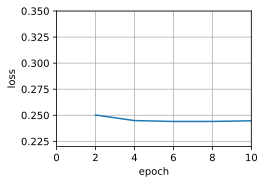

In [50]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data(batch_size) # 返回数据和X的维度
    return train(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss: 0.249, 0.168 sec/epoch


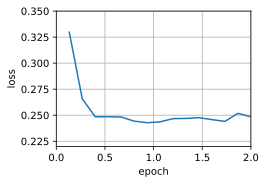

In [51]:
sgd_res = train_sgd(0.005, 1)

loss: 0.245, 0.008 sec/epoch


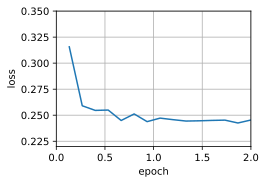

In [52]:
mini1_res = train_sgd(.4, 100)

loss: 0.242, 0.028 sec/epoch


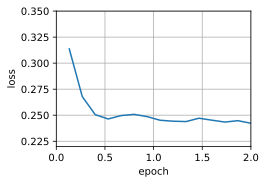

In [53]:
mini2_res = train_sgd(.05, 10)

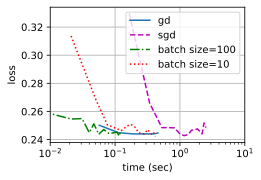

In [54]:
dltools.set_figsize([6, 3])
dltools.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))), 'time (sec)', 'loss', xlim=[1e-2, 10],legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
dltools.plt.gca().set_xscale('log')

In [55]:
# 简洁实现
def train_concise(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none') # 直接返回向量形式的 loss
    animator = dltools.Animator(xlabel='epoch', ylabel='loss',xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, dltools.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),(dltools.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.028 sec/epoch


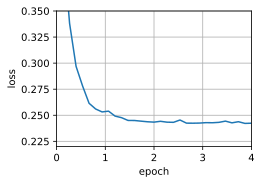

In [56]:
data_iter, _ = get_data(10)
trainer = torch.optim.SGD
train_concise(trainer, {'lr': 0.01}, data_iter)

In [43]:
data = np.genfromtxt("E:/data/airfoil_self_noise.dat",dtype=np.float32, delimiter='\t')
data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
data_iter = dltools.load_array((data[:n, :-1], data[:n, -1]),batch_size, is_train=True)

In [42]:
data.shape

torch.Size([1503, 6])

In [49]:
data[:n, :-1].shape, data[:n, -1].shape

(torch.Size([1500, 5]), torch.Size([1500]))